In [192]:
import numpy as np
from sklearn.datasets import load_iris
from gtda.homology import VietorisRipsPersistence,CubicalPersistence
from gtda.plotting import plot_point_cloud, plot_heatmap, plot_diagram
from gtda.images import Binarizer,RadialFiltration


from sklearn.pipeline import make_pipeline, make_union
from gtda.diagrams import PersistenceEntropy, Amplitude,PersistenceImage, Scaler
from gtda.images import HeightFiltration
from gtda.diagrams import Amplitude


from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Exercice 1. 

### 1. Ecrire un code Python pour calculer la matrice de distance associée à un ensemblende données dans un espace euclidien.

In [58]:
def euclidean_distance_matrix(X):
    # Vérify that X is a numpy array
    if not isinstance(X, np.ndarray):
        raise ValueError("X doit être un tableau numpy")
    
    # Clculate the euclidean distance
    n_samples, n_features = X.shape
    distances = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            dist = np.linalg.norm(X[i]-X[j])
            distances[i,j] = dist
            distances[j,i] = dist
    
    return distances


In [59]:
# upload iris data
iris = load_iris()
X = iris.data

# Calculate the distance matrix
distances = euclidean_distance_matrix(X)

# Print the first lines and columns
print(distances[:5,:5])


[[0.         0.53851648 0.50990195 0.64807407 0.14142136]
 [0.53851648 0.         0.3        0.33166248 0.60827625]
 [0.50990195 0.3        0.         0.24494897 0.50990195]
 [0.64807407 0.33166248 0.24494897 0.         0.64807407]
 [0.14142136 0.60827625 0.50990195 0.64807407 0.        ]]


### Utilisez la bibliothèque giotto-TDA pour créer un diagramme de persistance à partir de cette matrice de distance.

In [61]:
D_reshaped = D.reshape(1, *distances.shape)


# Compute the persistence diagram
rips = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])
diag_rips = rips.fit_transform(D_reshaped)

# Visualize the persistence diagram
rips.plot(diag_rips)


# Exercice 2.

### 1. Ecrire un code Python pour effectuer une classification de données à l’aide de giotto-TDA.

In [147]:
XX, target = fetch_openml('shapes', return_X_y=True)
XX

,x,y,z,target
0,0.341007,0.318606,0.096725,human_arms_out9
1,0.329226,0.421601,0.056749,human_arms_out9
2,0.446869,0.648674,0.124090,human_arms_out9
3,0.314729,0.217860,0.070847,human_arms_out9
4,0.426678,0.919195,0.047609,human_arms_out9
...,...,...,...,...
15995,0.483704,0.504718,0.099081,biplane8
15996,0.268092,0.688763,0.174801,biplane8
15997,0.315984,0.280097,0.056011,biplane8
15998,0.242428,0.913443,0.054996,biplane8


In [148]:
yy = XX.target

In [149]:
df =XX
plot_point_cloud(df.query('target == "biplane0"')[["x", "y", "z"]].values)

In [150]:
#Next, let’s collect all these point clouds in a single NumPy array:
point_clouds = np.asarray(
    [
        df.query("target == @shape")[["x", "y", "z"]].values
        for shape in df["target"].unique()
    ]
)
point_clouds.shape

(40, 400, 3)

In [153]:
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=[0,1,2],
    n_jobs=6,
    collapse_edges=True,
)
persistence_diagrams = persistence.fit_transform(point_clouds)

In [156]:
index = 20
plot_diagram(persistence_diagrams[index])

In [157]:
#Next we convert each diagram into a 3-dimensional vector using persistent entropy and plot the resulting feature matrix:

persistence_entropy = PersistenceEntropy(normalize=True)

# Calculate topological feature matrix
X = persistence_entropy.fit_transform(persistence_diagrams)

# Visualise feature matrix
plot_point_cloud(X)

In [160]:
labels = np.zeros(40)
labels[10:20] = 1
labels[20:30] = 2
labels[30:] = 3

rf = RandomForestClassifier(oob_score=True, random_state=42)
rf.fit(X, labels)
rf.oob_score_

0.6

###  2. Utilisez les données MNIST pour créer un modèle de classification supervisée en utilisant l’algorithme k-NN, le diagramme de persistance, le “landscape”, “bottleneck” et l’image persistance.

In [161]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml("mnist_784", version=1, return_X_y=True)

In [162]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (70000, 784), y shape: (70000,)


In [163]:
X = X.to_numpy()

In [164]:
im8_idx = np.flatnonzero(y == "8")[0]
img8 = X[im8_idx].reshape(28,28)
plot_heatmap(img8)

In [165]:
train_size, test_size = 80, 10

# Reshape to (n_samples, n_pixels_x, n_pixels_y)
X = X.reshape((-1, 28, 28))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, test_size=test_size, stratify=y, random_state=666
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (80, 28, 28), y_train shape: (80,)
X_test shape: (10, 28, 28), y_test shape: (10,)


In [169]:
direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_list = [
    [13, 6],
    [6, 13],
    [13, 13],
    [20, 13],
    [13, 20],
    [6, 6],
    [6, 20],
    [20, 6],
    [20, 20],
]

# Creating a list of all filtration transformer, we will be applying
filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline
diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),#processus de standedisation i.e b
    ]
    for filtration in filtration_list
]

# Listing all metrics we want to use to extract diagram amplitudes
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 2, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 1, "n_bins": 100}},
    {"metric": "landscape", "metric_params": {"p": 2, "n_layers": 2, "n_bins": 100}},
    {"metric": "persistence_image", "metric_params": {}},
]

#
feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)]
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

In [170]:
X_train_tda = tda_union.fit_transform(X_train)
X_train_tda.shape


(80, 238)

In [187]:

knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train_tda, y_train)

X_test_tda = tda_union.transform(X_test)
knn.score(X_test_tda, y_test)


0.6

### 3. Evaluez les performances de votre modèle en utilisant la précision et la matrice de confusion. 


In [188]:
y_pred = knn.predict(X_test_tda)

In [189]:
y_pred

array(['6', '6', '4', '9', '1', '0', '3', '3', '6', '4'], dtype=object)

In [190]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

In [191]:
confusion_matrix

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int64)

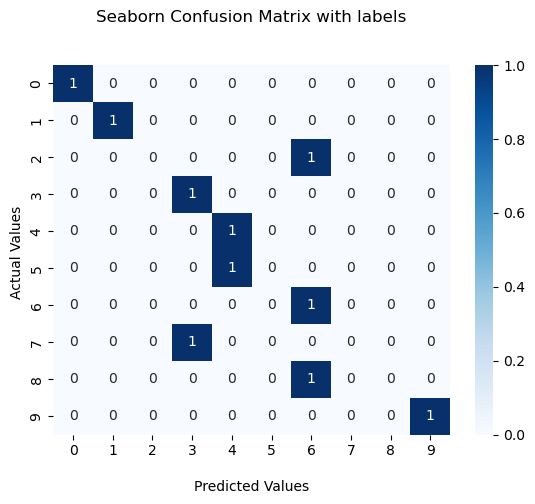

In [196]:
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()